# Beamforming - Contre-mesures RADAR
### Maxime BARRET

Avec l'aide de :
#### 'Signaux et Sytèmes' - Prof. Dr Ir Xavier Neyt 
#### 'Source Localization with sensor arrays' - Assistant Professors Charles Vanwynsberghe & Angélique Drémeau
#### 'Fundamentals of a Uniform Linear Array' - raymaps.com

In [109]:
%matplotlib notebook
#Indique qu'on va afficher des figures, et permet de les modifier

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd      #Imports d'usage
from scipy.signal import find_peaks
import time as t

#####
# Il manque une petite explications des différentes méthodes de Beamforming que j'utilise, 
###

### Situation initiale

La situation est la suivante : 
- Nous avons un Uniform Linear Array (ULA) décrit ci-après
- Ma source ne bouge pas pour l'instant
- M antennes dans mon array
- d : distance entre mes antennes dans mon array (doit être cohérente avec la taille d'un UGV/UAV)
- Le problème est plan
- Meilleur des mondes


Avec notre array, on mesure : 

$$ \mathbf{y}_l = \sum_{s=1}^{S} x_s \mathbf{a}(\theta_s)  + \mathbf{n}_l $$ 

Ici, S=1 : un seul RADAR éclaire notre cible, du moins pour l'instant

Le diagramme de rayonnement de notre ULA
$DP(\theta) = 20 \log_{10} \left( \dfrac{\mathbf{a}(\theta)^H \mathbf{a}(\theta_0)}{\|\mathbf{a}(\theta)\|^2} \right)$ dB.




### Description de notre ULA

![](ULA.jpg)

### Déclaration de nos variables

En choisissant nos variables, nous devons faire attention à plusieurs choses :
- Rester cohérent avec la réalité : On ne va pas mettre 100000000 de capteurs, ni avoir une fréquence de 2 Hz
- Vérifier la condition d'échantillonnage spatial, ici : $ d < \dfrac{\lambda}{2} ) $

![](Shannon.jpg)

In [110]:
t1 = t.time()
c0 = 3e8   #célérité de la lumière dans l'air 
d = 0.4          #Distance entre mes émetteurs
M = 5              #Nombre d'émetteurs sur ma cible
N = 4*721
angle = np.linspace(-np.pi/2,np.pi/2,N)     #Grille sur laquel on va chercher l'angle d'incidence

theta0 = 0   #Angle d'incidence auquel se situe le radar qu'on doit tromper : là, il est en face de la cible.
lam = 1  #Correspond à une fréquence de 300 Mhz


In [111]:
def a(theta,lam,M):
    """
    Fonction renvoyant le steering vector
    :param theta: angle thêta
    :param lam: longueur d'onde
    :param M: nombre de capteurs (Donc ici nombre d'émetteurs)
    :return: array
    """
    res = np.zeros(M, dtype=complex)
    for i in range(0, M):
        res[i] = np.exp(-1j * (2 * np.pi * d * i * np.sin(theta) / lam))
    return res

def compute_A(thetas,lam,M):
    """
    Fonction renvoyant la steering matrix, qui serait la concaténation des steering vectors pour chaque theta
    :param thetas: liste d'angles
    :param lam: longueur d'onde
    :param M: nombre de capteurs (Donc ici nombre d'émetteurs)
    :return: 2D array
    """
    res = np.zeros((len(thetas), M), dtype = complex)
    
    for i in range(len(thetas)):
        lis = np.zeros(M, dtype = complex)
        for k in range(0,M):
            lis[k] = np.exp(-1j * (2*np.pi*d*k*np.sin(thetas[i]) /lam))
        res[i] = lis
    return res.T

In [112]:
def DP(theta):
    """
    Schéma directionnel  (directivity pattern)
    :param theta:
    :return:
    """
    A = a(theta,lam,M)
    temp = np.dot(np.conj(A).T, a(theta0,lam,M))
    dp = 20*np.log10(temp/(np.linalg.norm(a(theta,lam,M))**2))
    return dp



## Affichage des Diagrammes de Rayonnement de notre ULA avec des sources situées à des angles différents

<IPython.core.display.Javascript object>


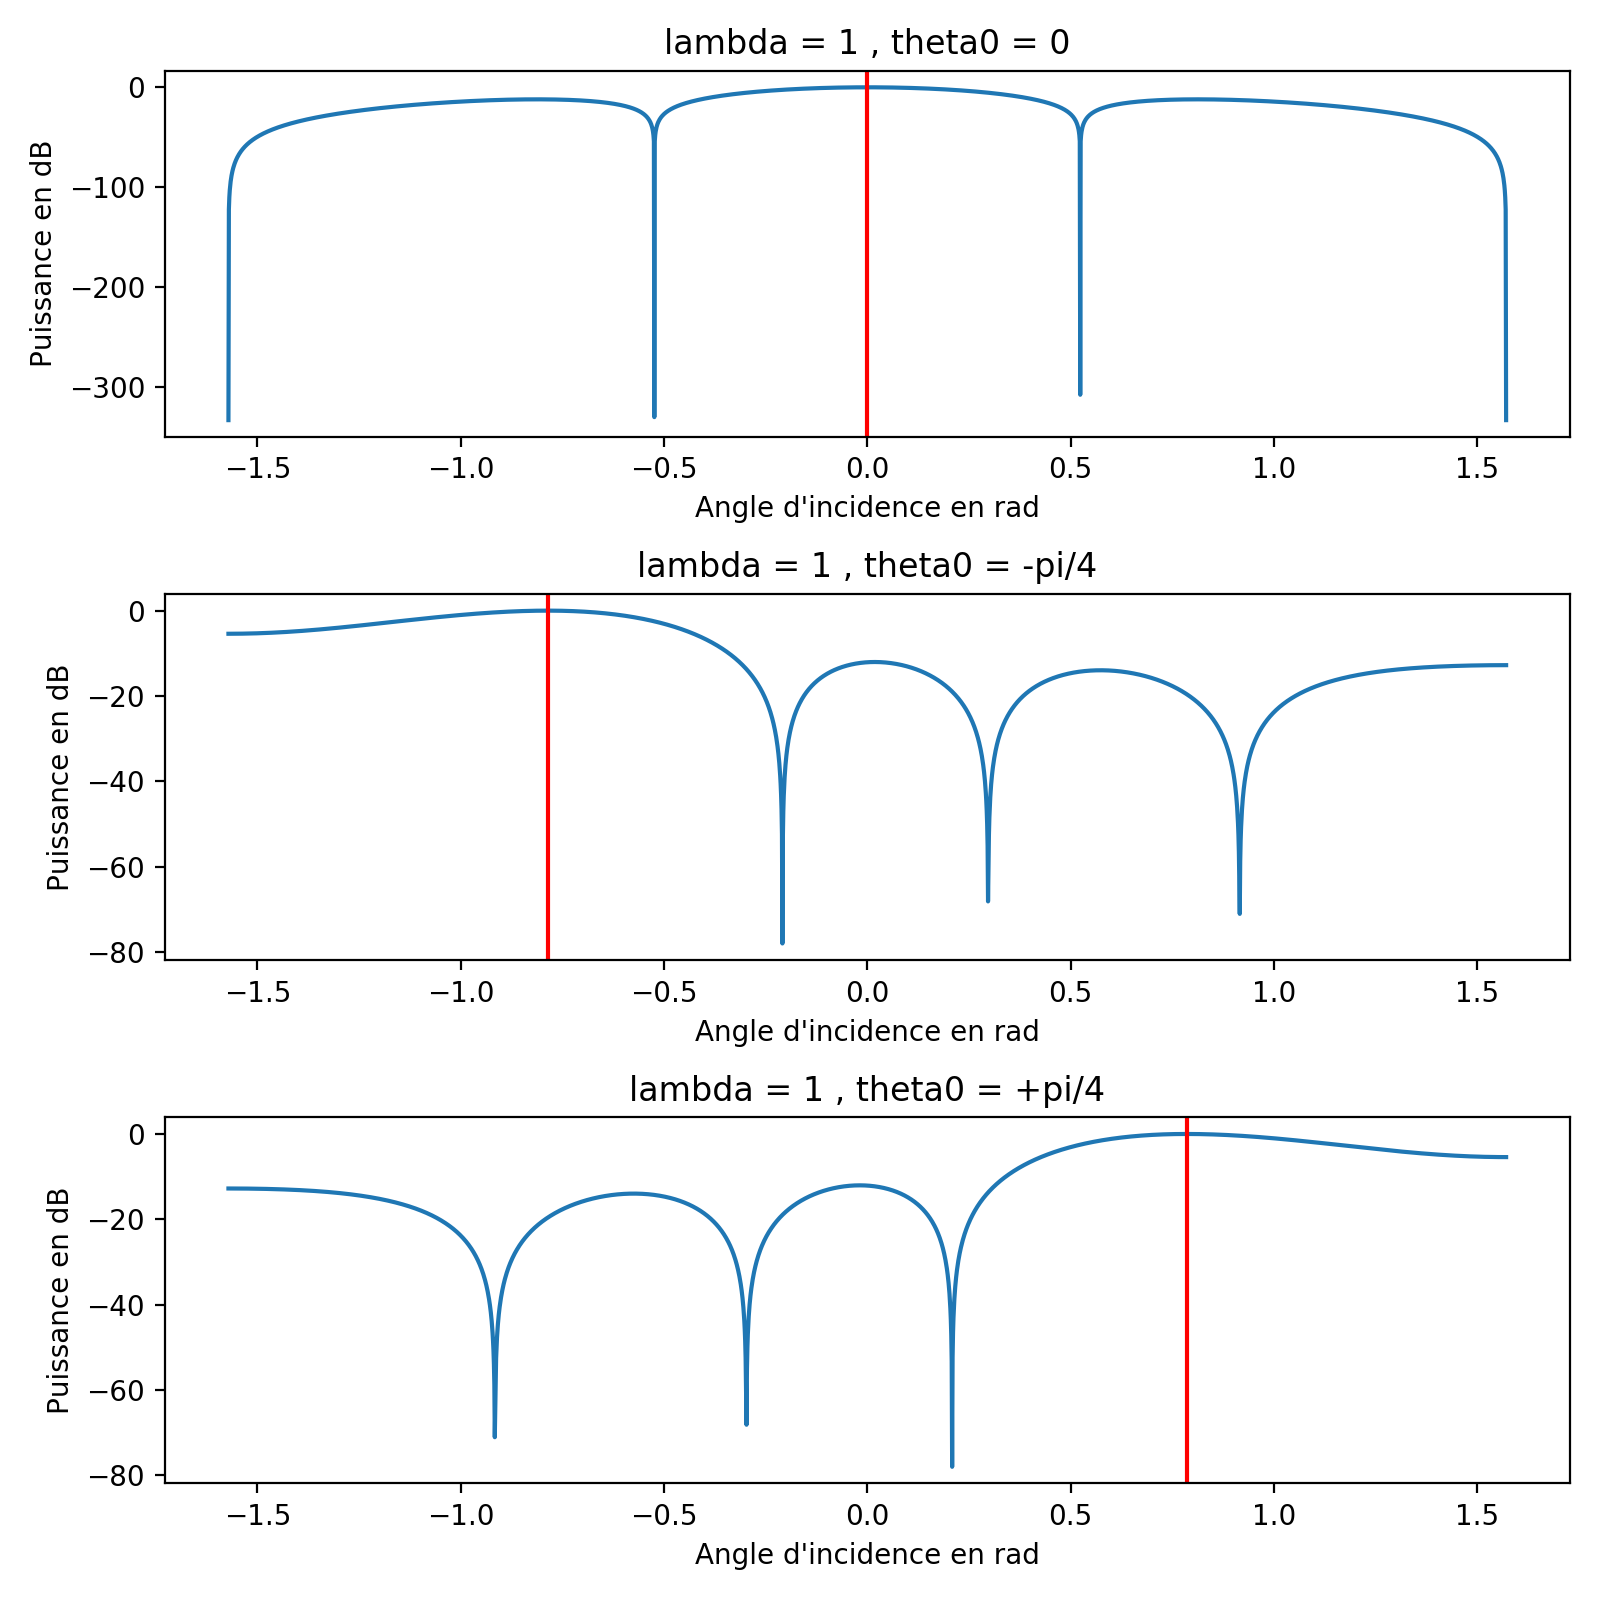

In [113]:
DPs = {}  #Je répertorie mes différents diagramme de rayonnement dans un dict pour y avoir plus facilement accès 
s_angles = [-np.pi/4,np.pi/12,np.pi/6]  #Liste des positions angulaires de différentes sources
S = len(s_angles)

theta0 = 0   #Angle

lam = 1
plt.figure(figsize=(8,8))
plt.subplot(311)
DP01 = []
for i in range(N):
    DP01.append(DP(angle[i]))
DPs["0"] = DP01
plt.title("lambda = 1 , theta0 = 0")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DP01)
plt.axvline(theta0,color='r')


#Autre source
theta0 = - np.pi/4

plt.subplot(312)
DPpi1 = []
for i in range(N):
    DPpi1.append(DP(angle[i]))
DPs["-pi/4"] = DPpi1
plt.title("lambda = 1 , theta0 = -pi/4")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DPpi1)
plt.axvline(theta0,color='r')


#Autre source
theta0 = np.pi/4

plt.subplot(313)
DPpi2 = []
for i in range(N):
    DPpi2.append(DP(angle[i]))
DPs["pi/4"] = DPpi2
plt.title("lambda = 1 , theta0 = +pi/4")
plt.xlabel("Angle d'incidence en rad")
plt.ylabel("Puissance en dB")
plt.plot(angle,DPpi2)
plt.axvline(theta0,color='r')

plt.tight_layout()
plt.show()

#Je répertorie mes différents diagramme de rayonnement



## Détection de la direction de la source

Dans l'idée, il faudrait dans un premier temps repérer la (Ou les) sources qui éclairent notre cible, en fonction de ce que mesure notre array dans le temps.
On va vérifier la validité des différentes méthodes en fonction de tous les paramètres, et qui plus est du RSB :
$SNR = \log_{10}\left( \dfrac{\|\mathbf{A} \mathbf{S}_{xx} \mathbf{A}^H\|_F}{\|\mathbf{S}_{nn}\|_F} \right)$

### Classical Beamforming

In [114]:
res = {}
#Dans le dictionnaire res, on va stocker tous les résultats de nos détection de sources

##################### Classical beamforming ##############################

s_amp = [2,1,0.5]   #Amplitude du signal reçu
L = 64   #Nombre de mesures effectuées par notre array
sig_n = 3e-1   #Ecart-type de notre bruit, que je vais considérer Gaussien


temp = rd.randn(S,L)
n = sig_n*(rd.randn(M,L))  #Gaussien centré
s = np.sin(2*np.pi*c0*temp/4) #Je génère un signal aléatoire
for i in range(len(s_amp)):
    s[i] *= s_amp[i]
A = compute_A(s_angles,lam,M)
y = A@s + n     #On retrouve bien la linéarité


snr = np.log10(np.linalg.norm(A @ s @ (A @ s).T.conj())/np.linalg.norm(n@ n.T.conj()))
print(f"Le RSB est de {snr} dB")


print(f"Notre vecteur y est de dimension {y.shape}, et chaque ligne représente l'acquisition d'un des capteur de l'array")


#Calcul de la matrice de covariance des y
Syy = y @ y.T.conj() / L

angles1 = np.linspace(- np.pi/2,np.pi/2,N)
PCBF = np.zeros(N, dtype = complex)   #Ça signifie Puissance pour du classic beamforming 
                                        # Un pic de puissance indiquera la position de notre source

for i in range(N):
    a_pcbf = a(angles1[i], lam,M)
    PCBF[i] = a_pcbf.T.conj() @ Syy @ a_pcbf / (np.linalg.norm(a_pcbf) ** 4)

res["PCBF"]=PCBF





Le RSB est de 1.7288858346550728 dB
Notre vecteur y est de dimension (5, 64), et chaque ligne représente l'acquisition d'un des capteur de l'array


## MVDR : Minimum Variance Distortionless Response

In [115]:

PMVDR = np.zeros(N, dtype = complex)
for i in range(N):
    a_pmvdr = a(angle[i], lam,M)
    PMVDR[i] = 1/(np.conj(a_pmvdr.T) @ np.linalg.inv(Syy) @ a_pmvdr)
    
res["MVDR"]=PMVDR

### MUSIC - Singular values decomposition

In [116]:


#Principe : Décomposer notre Syy en valeurs singulières, ce qui nous permet de d'appliquer une petite formule sympa cf C3-C4 slides 47 à 51
eig = np.linalg.eig(Syy)    #On calcule les valeurs propres et des vecteurs propres de la matrice de covariance
eigvals = eig[0]
Diagonale = np.diag(eigvals)   

U = eig[1]
#Où commence le sous-espace contenant le bruit? à S+1 !
Unoise = U[:,S:]

Sx = np.conj(A).T @ Syy @ A

PMUSIC= np.zeros(N, dtype = complex)
for i in range(N):
    a_music = a(angle[i], lam,M)
    PMUSIC[i] = 1 / (np.conj(a_music).T @ Unoise@np.conj(Unoise.T)@a_music)
    
res["MUSIC"] = PMUSIC



### Affichages des véritables directions de nos sources, et des différentes méthodes de détection

Selon le CBF, on trouve les directions suivantes : [-0.78076696  0.24354699]
Selon MUSIC, on trouve les directions suivantes : [-0.78403604  0.25662333  0.55737934]
Selon MVDR, on trouve les directions suivantes : [-0.78403604  0.27732755]


<IPython.core.display.Javascript object>


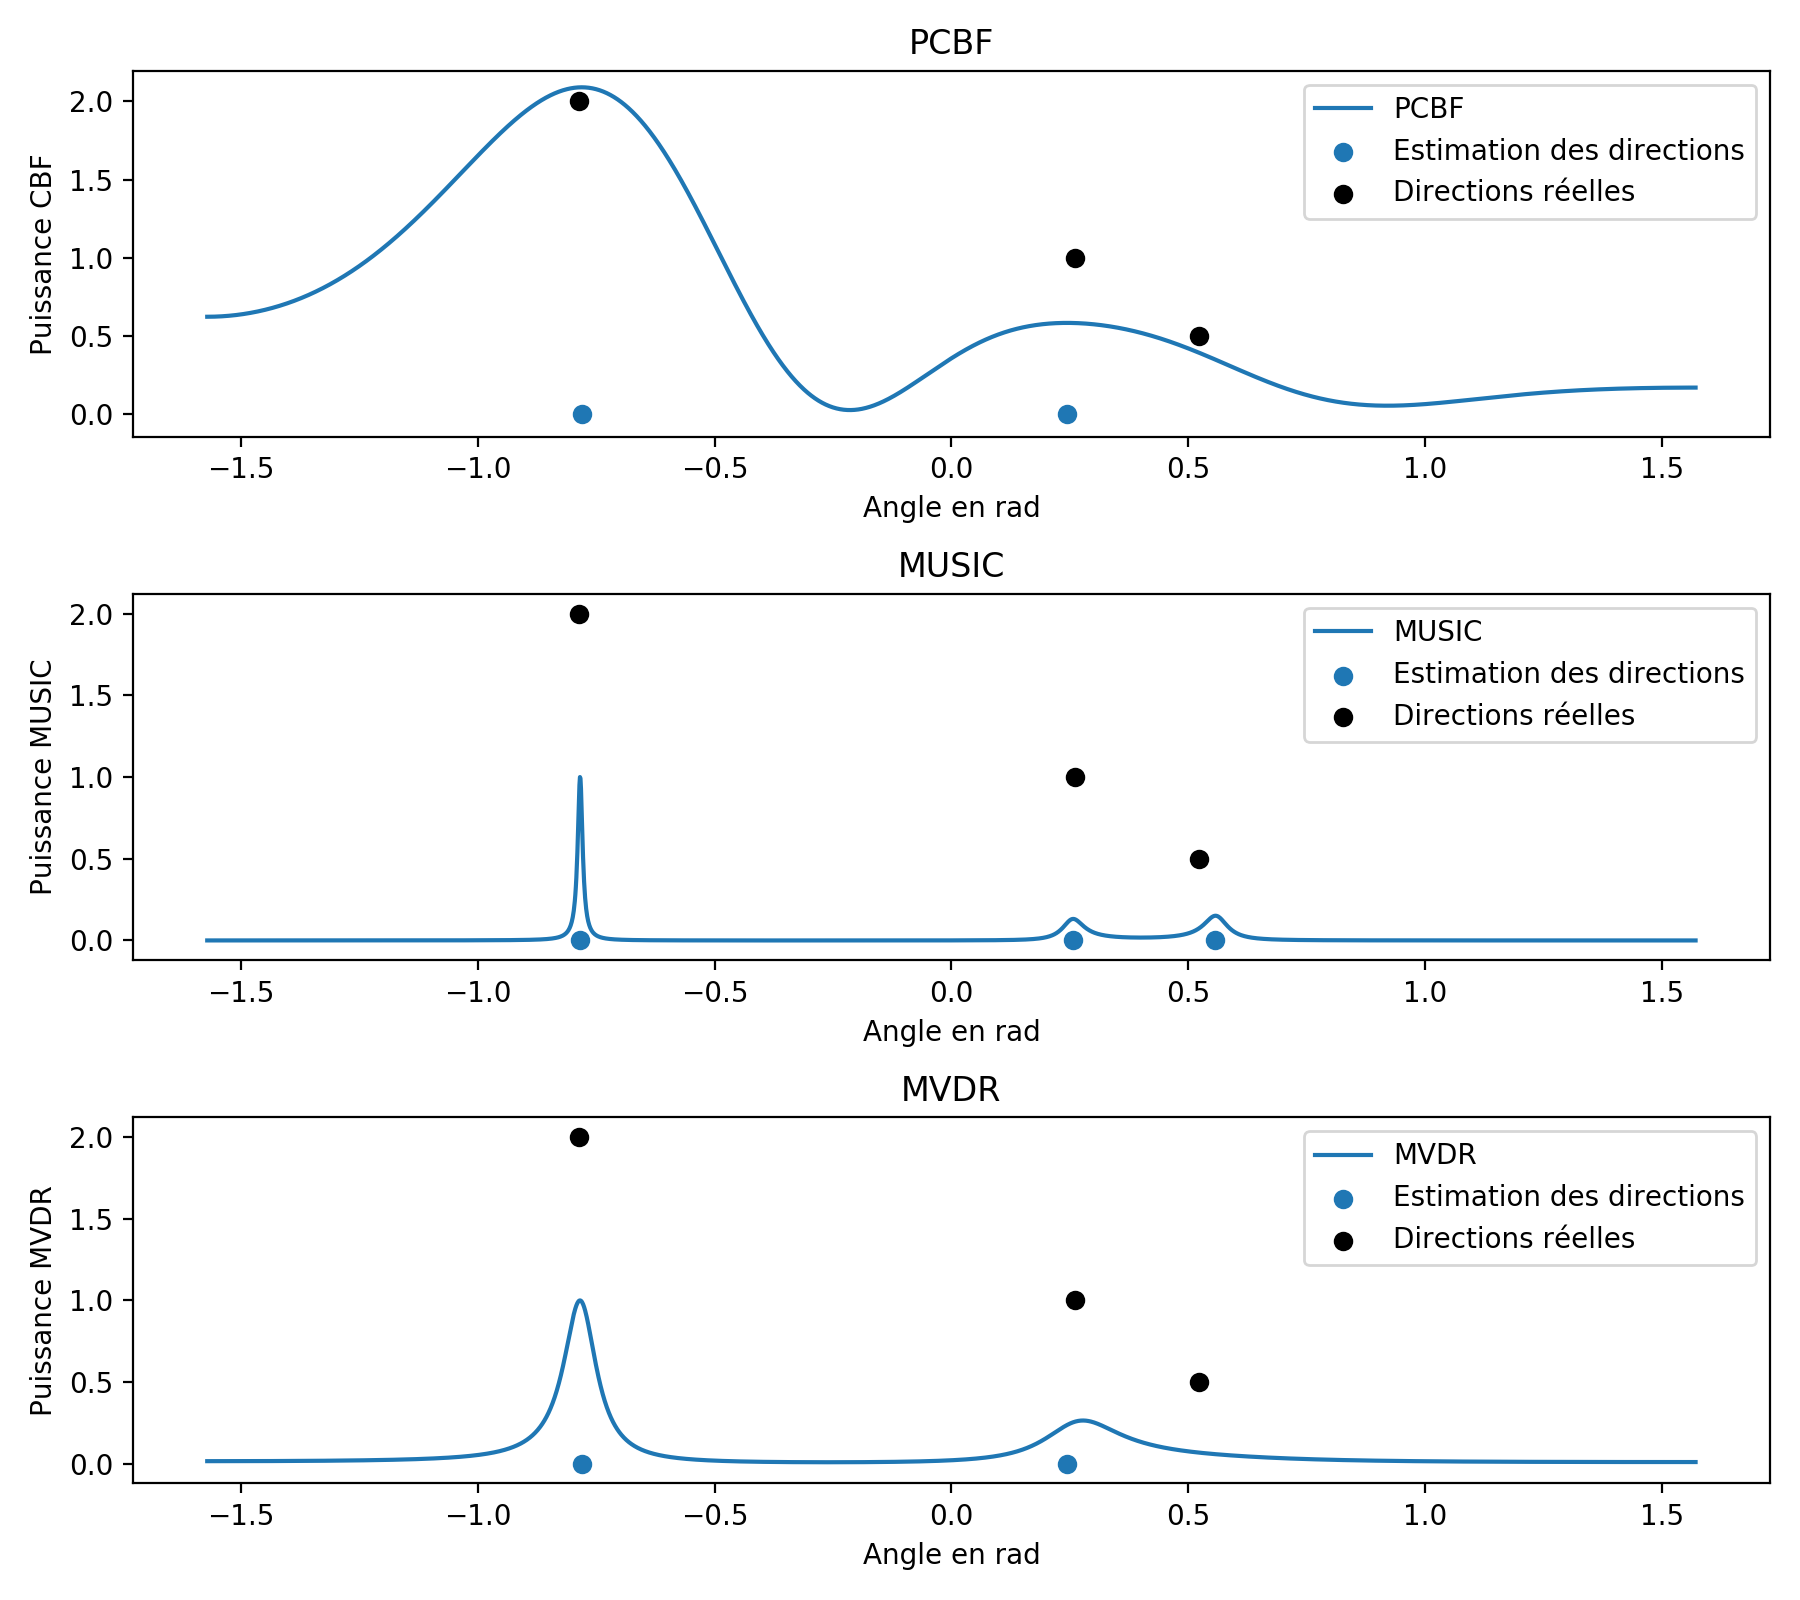

SOURCE(S) NON DETECTEE(S) par PCBF
SOURCE(S) NON DETECTEE(S) par MVDR
Temps de calcul pour 5 capteurs, avec 2884 possibles d'angles valeurs  : 2.0395851135253906


In [117]:
peakind1 = find_peaks(PCBF,threshold=0)
peakind2 = find_peaks(PMUSIC,threshold=0)
peakind3 = find_peaks(PMVDR,threshold=0)
k1,k2,k3 = len(peakind1[0]),len(peakind2[0]),len(peakind3[0])

print(f"Selon le CBF, on trouve les directions suivantes : {angle[peakind1[0]]}")
print(f"Selon MUSIC, on trouve les directions suivantes : {angle[peakind2[0]]}")
print(f"Selon MVDR, on trouve les directions suivantes : {angle[peakind3[0]]}")
    
plt.figure(figsize=(9,8))

plt.subplot(311)
plt.title("PCBF")
plt.xlabel("Angle en rad")
plt.ylabel("Puissance CBF")
plt.plot(angle, PCBF,label='PCBF')

if len(angle[peakind1[0]]) != len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par PCBF")
    plt.scatter(angle[peakind1[0]],k1*[0],label='Estimation des directions')
else:
    plt.scatter(angle[peakind1[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()

plt.subplot(312)
plt.title("MUSIC")
plt.plot(angle, PMUSIC/np.max(PMUSIC),label='MUSIC')
plt.xlabel("Angle en rad")
plt.ylabel("Puissance MUSIC")
if len(angle[peakind2[0]]) != len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par MUSIC")
    plt.scatter(angle[peakind1[0]],k2*[0],label='Estimation des directions')
else: 
    plt.scatter(angle[peakind2[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()

plt.subplot(313)
plt.title("MVDR")
plt.plot(angle, PMVDR/np.max(PMVDR),label='MVDR')
plt.xlabel("Angle en rad")
plt.ylabel("Puissance MVDR")
if len(angle[peakind3[0]]) != len(s_angles):
    print("SOURCE(S) NON DETECTEE(S) par MVDR")
    plt.scatter(angle[peakind1[0]],k3*[0],label='Estimation des directions')
else: 
    plt.scatter(angle[peakind3[0]],S*[0],label='Estimation des directions')
plt.scatter(s_angles, s_amp, color='k',label='Directions réelles')
plt.legend()


plt.tight_layout()
plt.show()

t2 = t.time()
time = t2-t1
print(f"Temps de calcul pour {M} capteurs, avec {N} possibles d'angles valeurs  : {time}")

#### Comparaison des performances

$ err = \dfrac{| \theta_(estimé) - \theta |}{\theta} ) $

In [125]:
err = {}
for key in res.keys():
    print(f"###### {key}")
    temp = find_peaks(res[key],threshold=0)[0]
    err_temp = []
    k = len(s_angles)
    for i in range(0,len(temp)):
        if s_angles[i]!=0:
            err_temp.append(100*np.abs((angle[temp[i]]-s_angles[i])/s_angles[i]))
        else:
            err_temp.append(100*np.abs(angle[temp[i]]))
        print(f"l'erreur pour la source {i} est de {round(err_temp[i],4)} %")
    err[key] = err_temp
    print("\n")

    
print(err)

###### PCBF
l'erreur pour la source 0 est de 0.5897 %
l'erreur pour la source 1 est de 6.9719 %


###### MVDR
l'erreur pour la source 0 est de 0.1734 %
l'erreur pour la source 1 est de 5.9313 %


###### MUSIC
l'erreur pour la source 0 est de 0.1734 %
l'erreur pour la source 1 est de 1.9771 %
l'erreur pour la source 2 est de 6.4516 %


{'PCBF': [0.58966354491849, 6.971904266389189], 'MVDR': [0.173430454387797, 5.93132154006245], 'MUSIC': [0.173430454387797, 1.9771071800207884, 6.451612903225841]}


<IPython.core.display.Javascript object>


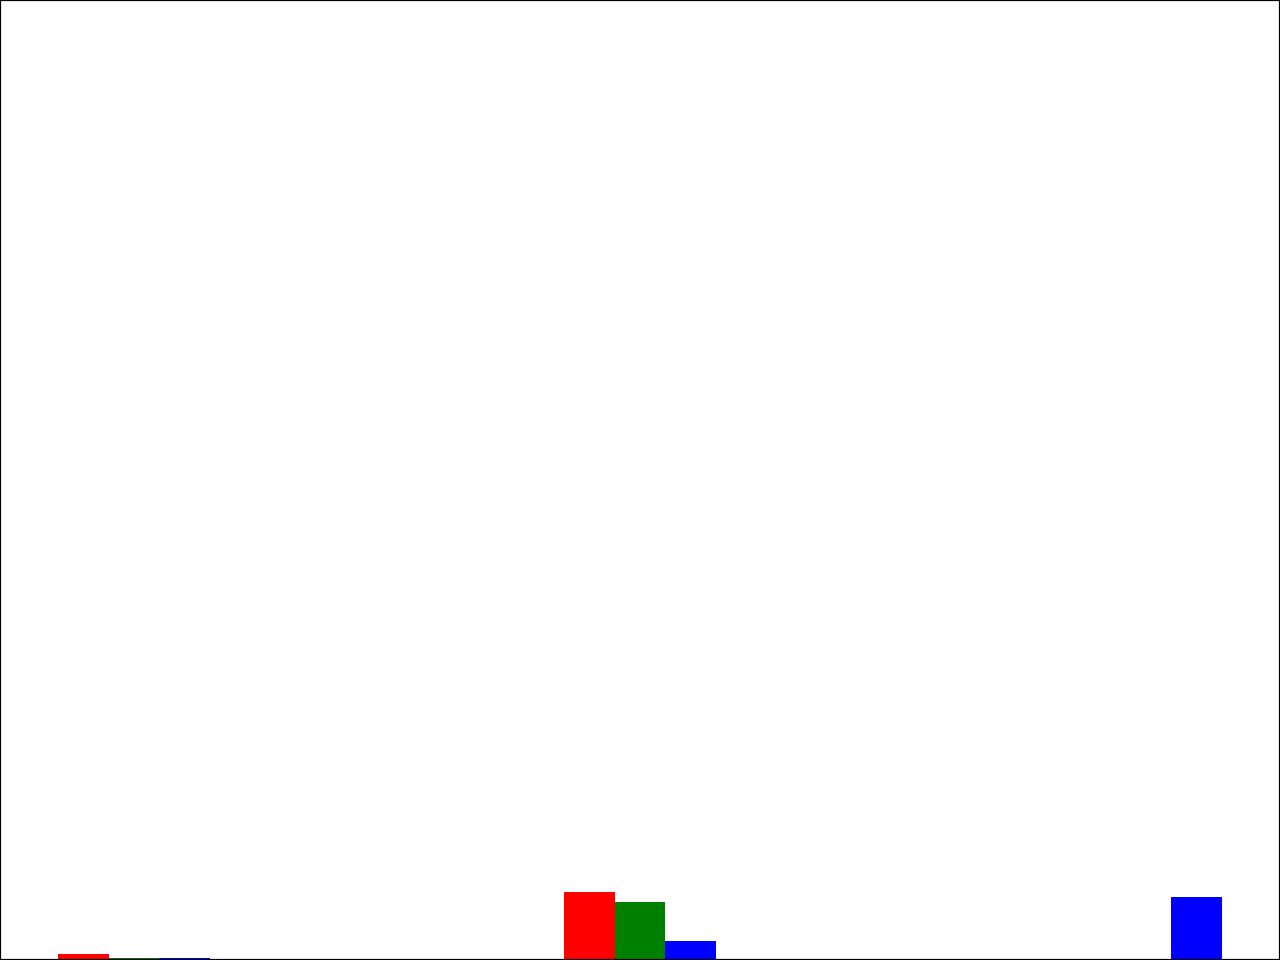

0.58966354491849
6.971904266389189
0.173430454387797
5.93132154006245
0.173430454387797
1.9771071800207884
6.451612903225841


In [122]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(s_angles))
col = ['r','g','b']

for k,key in enumerate(err.keys()):
    for i in range(len(err[key])):
        ax.bar(i+ 0.1*k,err[key][i],color=col[k], width = 0.1)
        print(err[key][i])
        ax.set_yticks(np.arange(0,100))

#Bon, la légende ne s'affiche pas....

## Placement de zéros

Maintenant que nous avons les directions d'intérêt, il faut limiter la puissance du diagramme de rayonnement de notre array dans celles-ci. 


## Cible en mouvement 

Il faut maintenant intégrer le fait que notre UAV/UGV soit en mouvement. Ou bien, si on se place dans le référentiel de l'UAV, les sources bougent. 
Je viens de me rendre compte que ce que je fais ne donne que des directions, et pas les distances... 